In [18]:
import os,re,sys
import pandas as pd
import numpy as np
import seaborn as sns # visualisation
import matplotlib.pyplot as plt # visualisation
np.random.seed(2019)
import xgboost as xgb
import lightgbm as lgb
#import catboost as ctb
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict, Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, RobustScaler
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score as auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score as auc
os.chdir("D:\\Imarticus\\ML-Repeat\\ml_08November")
%matplotlib inline


In [19]:
df=pd.read_csv("attrition.csv")

In [3]:
df.shape

(1470, 35)

In [4]:
df.head()

,Attrition,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1,41,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,0,49,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,1,37,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,0,33,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,0,27,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [6]:
df['Department'].value_counts()/len(df)

Research & Development    0.653741
Sales                     0.303401
Human Resources           0.042857
Name: Department, dtype: float64

In [8]:
df['EducationField'].value_counts()/len(df)

Life Sciences       0.412245
Medical             0.315646
Marketing           0.108163
Technical Degree    0.089796
Other               0.055782
Human Resources     0.018367
Name: EducationField, dtype: float64

In [12]:
df['Over18'].value_counts()/len(df)

Y    1.0
Name: Over18, dtype: float64

In [7]:
df.isnull().sum()

Attrition                   0
Age                         0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [20]:
### Encoding Prediction Class
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

#trainF['Severity_label'], _ = pd.factorize(trainF['Severity'])

df['Department']=le.fit_transform(df['Department'].values)
df['EducationField']=le.fit_transform(df['EducationField'].values)
df['BusinessTravel']=le.fit_transform(df['BusinessTravel'].values)

In [21]:
df['Gender']=le.fit_transform(df['Gender'].values)
df['JobRole']=le.fit_transform(df['JobRole'].values)
df['MaritalStatus']=le.fit_transform(df['MaritalStatus'].values)
df['Over18']=le.fit_transform(df['Over18'].values)
df['OverTime']=le.fit_transform(df['OverTime'].values)


In [22]:
df.head()

,Attrition,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1,41,2,1102,2,1,2,1,1,1,...,1,80,0,8,0,1,6,4,0,5
1,0,49,1,279,1,8,1,1,1,2,...,4,80,1,10,3,3,10,7,1,7
2,1,37,2,1373,1,2,2,4,1,4,...,2,80,0,7,3,3,0,0,0,0
3,0,33,1,1392,1,3,4,1,1,5,...,3,80,0,8,3,3,8,7,3,0
4,0,27,2,591,1,2,1,3,1,7,...,4,80,1,6,3,3,2,2,2,2


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
Attrition                   1470 non-null int64
Age                         1470 non-null int64
BusinessTravel              1470 non-null int32
DailyRate                   1470 non-null int64
Department                  1470 non-null int32
DistanceFromHome            1470 non-null int64
Education                   1470 non-null int64
EducationField              1470 non-null int32
EmployeeCount               1470 non-null int64
EmployeeNumber              1470 non-null int64
EnvironmentSatisfaction     1470 non-null int64
Gender                      1470 non-null int32
HourlyRate                  1470 non-null int64
JobInvolvement              1470 non-null int64
JobLevel                    1470 non-null int64
JobRole                     1470 non-null int32
JobSatisfaction             1470 non-null int64
MaritalStatus               1470 non-null int32
MonthlyIncome               1

In [61]:
from sklearn.metrics import log_loss

def run_cv_model(train, test, target, model_fn, params={}, eval_fn=None,label='model', n_folds=5):
    kf = StratifiedKFold(n_splits=n_folds, shuffle = True, random_state = 228)
    fold_splits = kf.split(train, target)
    cv_scores = []
    pred_full_test = 0
    pred_train = np.zeros((train.shape[0]))
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = test.columns
    i = 1
    for dev_index, val_index in fold_splits:
        print('-------------------------------------------')
        print('Started ' + label + ' fold ' + str(i) + f'/{n_folds}')
        dev_X, val_X = train.iloc[dev_index], train.iloc[val_index]
        dev_y, val_y = target.iloc[dev_index], target.iloc[val_index]
        params2 = params.copy()
        pred_val_y, pred_test_y, fi,model = model_fn(dev_X, dev_y, val_X, val_y, test, params2)
        feature_importances[f'fold_{i}'] = fi
        pred_full_test = pred_full_test + pred_test_y
        pred_train[val_index] = pred_val_y
        #if eval_fn is not None:
            #cv_score = eval_fn(val_y, pred_val_y)
        try:
            print(val_y.shape)
            print(pred_val_y.shape)
            print('f1 score is {}'.format(f1_score(val_y, pred_val_y, average='micro') ))
            cv_score=f1_score(val_y, pred_val_y, average='micro')
            print('cvscore is {}'.format(cv_score))
            cv_scores.append(cv_score)
            print(label + ' cv score {}: {}'.format(i, cv_score), '\n')
        except:
            print('in loop number {}'.format(i))
            
            break
        i += 1
        
    print('{} cv scores : {}'.format(label, cv_scores))
    print('{} cv mean score : {}'.format(label, np.mean(cv_scores)))
    print('{} cv std score : {}'.format(label, np.std(cv_scores)))
    pred_full_test = pred_full_test / n_folds
    results = {'label': label,
              'train': pred_train, 'test': pred_full_test,
              'cv': cv_scores, 'fi': feature_importances}
    return results,model

parameters = {
    #'application': 'binary',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_class':1,
    'num_leaves': 10,
    'feature_fraction': 0.85,
    'bagging_fraction': 0.95,
    'bagging_freq': 10,
    'learning_rate': 0.03,
    'verbose': 1 }




def lgbmodel(dev_X, dev_y, val_X, val_y, test, params2):
    
    train_data = lgb.Dataset(dev_X, label=dev_y)
    test_data = lgb.Dataset(val_X, label=val_y)

   
    model = lgb.train(parameters,
                           train_data,
                           valid_sets=test_data,
                           num_boost_round=200,
                           early_stopping_rounds=40)
    feature_im = model.feature_importance()
    
    print('Predict 1/2')
    pred_test_y = model.predict(val_X).argmax(axis=1)
    print('len of pred_test_y is {}'.format(pred_test_y.shape))
    print('Predict 2/2')
    pred_test_y2 = model.predict(test).argmax(axis=1)
    print('len of pred_test_y2 is {}'.format(pred_test_y2.shape))
    return pred_test_y, pred_test_y2, feature_im,model


    


In [55]:
df.head()

,Attrition,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1,41,2,1102,2,1,2,1,1,1,...,1,80,0,8,0,1,6,4,0,5
1,0,49,1,279,1,8,1,1,1,2,...,4,80,1,10,3,3,10,7,1,7
2,1,37,2,1373,1,2,2,4,1,4,...,2,80,0,7,3,3,0,0,0,0
3,0,33,1,1392,1,3,4,1,1,5,...,3,80,0,8,3,3,8,7,3,0
4,0,27,2,591,1,2,1,3,1,7,...,4,80,1,6,3,3,2,2,2,2


In [56]:
x_train, x_valid, y_train, y_valid = train_test_split(df-df['Attrition'], df['Attrition'],
                                         test_size=0.1, random_state=42, stratify=df['Attrition'],shuffle=True)


In [57]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [68]:
n_folds = 10
results,model = run_cv_model(x_train, x_valid, y_train, lgbmodel, parameters,f1_score,'f1', n_folds=n_folds)


-------------------------------------------
Started f1 fold 1/10
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Info] Number of positive: 191, number of negative: 999
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 1190, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160504 -> initscore=-1.654481
[LightGBM] [Info] Start training from score -1.654481
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's binary_logloss: 0.583249
Training until validation scores don't improve for 40 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	valid_0's binary_logloss: 0.583249
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[3]	valid_0's binary_logloss: 0.583249
[LightGBM] [Warning] Stopped tr

AxisError: axis 1 is out of bounds for array of dimension 1

In [64]:
## final model

train_data = lgb.Dataset(x_train, label=y_train)
test_data = lgb.Dataset(x_valid, label=y_valid)
model = lgb.train(parameters,train_data,valid_sets=test_data,num_boost_round=500,early_stopping_rounds=40)

[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Info] Number of positive: 213, number of negative: 1110
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 1323, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160998 -> initscore=-1.650823
[LightGBM] [Info] Start training from score -1.650823
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's binary_logloss: 0.575205
Training until validation scores don't improve for 40 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	valid_0's binary_logloss: 0.575205
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[3]	valid_0's binary_logloss: 0.575205
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requ

In [72]:
### Predicting on Test data and inversing the label encoding
predTest=model.predict(x_valid)

In [73]:
xgb2 = xgb.XGBClassifier(max_depth=7, n_estimators=1200, learning_rate=0.04,objective="multi:softmax",
                         tree_method='auto',random_state=42,colsample_bytree=0.8,subsample=0.85,
                        eval_metric ="mlogloss",
                        gamma=0.2,reg_alpha=0.4,min_child_weight = 3)

In [78]:
## xgboost
eval_set = [(x_train, y_train), (x_valid, y_valid)]
kfold = StratifiedKFold(n_splits=10, random_state=7)
results = cross_val_score(xgb2, x_train, y_train, cv=kfold)
#xgb2.fit(x_train[colneeded], x_train['damage_grade'],early_stopping_rounds=120, eval_metric=["mlogloss"],eval_set=eval_set)

C:\Users\Adhvaidh\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  if y_train is None:


XGBoostError: value 0 for Parameter num_class should be greater equal to 1

In [243]:
results

array([0.9578714 , 0.96008869, 0.9556541 , 0.96230599, 0.96111111,
       0.95777778, 0.95991091, 0.96547884, 0.95434298, 0.96659243])

In [155]:
#results ## original

array([0.95898004, 0.95898004, 0.94678492, 0.96119734, 0.95555556,
       0.95555556, 0.95879733, 0.96659243, 0.95434298, 0.96547884])

In [211]:
xgb2.fit(x_train[colneeded], x_train['Severity_Label'],early_stopping_rounds=30, eval_metric=["mlogloss"],eval_set=eval_set)


[0]	validation_0-mlogloss:1.36568	validation_1-mlogloss:1.36658
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-mlogloss:1.34833	validation_1-mlogloss:1.35081
[2]	validation_0-mlogloss:1.32667	validation_1-mlogloss:1.3303
[3]	validation_0-mlogloss:1.30376	validation_1-mlogloss:1.30825
[4]	validation_0-mlogloss:1.28402	validation_1-mlogloss:1.28926
[5]	validation_0-mlogloss:1.26137	validation_1-mlogloss:1.26758
[6]	validation_0-mlogloss:1.23972	validation_1-mlogloss:1.24649
[7]	validation_0-mlogloss:1.2173	validation_1-mlogloss:1.22486
[8]	validation_0-mlogloss:1.19849	validation_1-mlogloss:1.20716
[9]	validation_0-mlogloss:1.18219	validation_1-mlogloss:1.1918
[10]	validation_0-mlogloss:1.16677	validation_1-mlogloss:1.1771
[11]	validation_0-mlogloss:1.14952	validation_1-mlogloss:1.16074
[12]	validation_0-mlogloss:1.1384	validation_1-mlogloss:1.15084
[13

[121]	validation_0-mlogloss:0.368748	validation_1-mlogloss:0.430679
[122]	validation_0-mlogloss:0.365489	validation_1-mlogloss:0.427696
[123]	validation_0-mlogloss:0.363125	validation_1-mlogloss:0.42556
[124]	validation_0-mlogloss:0.360069	validation_1-mlogloss:0.422714
[125]	validation_0-mlogloss:0.356955	validation_1-mlogloss:0.419822
[126]	validation_0-mlogloss:0.352121	validation_1-mlogloss:0.414991
[127]	validation_0-mlogloss:0.348586	validation_1-mlogloss:0.411654
[128]	validation_0-mlogloss:0.3453	validation_1-mlogloss:0.408636
[129]	validation_0-mlogloss:0.341921	validation_1-mlogloss:0.40526
[130]	validation_0-mlogloss:0.33768	validation_1-mlogloss:0.401127
[131]	validation_0-mlogloss:0.335386	validation_1-mlogloss:0.399272
[132]	validation_0-mlogloss:0.331872	validation_1-mlogloss:0.396006
[133]	validation_0-mlogloss:0.328188	validation_1-mlogloss:0.392475
[134]	validation_0-mlogloss:0.325733	validation_1-mlogloss:0.39018
[135]	validation_0-mlogloss:0.324227	validation_1-mlog

[242]	validation_0-mlogloss:0.156164	validation_1-mlogloss:0.233455
[243]	validation_0-mlogloss:0.155451	validation_1-mlogloss:0.232828
[244]	validation_0-mlogloss:0.154785	validation_1-mlogloss:0.232207
[245]	validation_0-mlogloss:0.153704	validation_1-mlogloss:0.231205
[246]	validation_0-mlogloss:0.153268	validation_1-mlogloss:0.230925
[247]	validation_0-mlogloss:0.152118	validation_1-mlogloss:0.229887
[248]	validation_0-mlogloss:0.151573	validation_1-mlogloss:0.229408
[249]	validation_0-mlogloss:0.150747	validation_1-mlogloss:0.228643
[250]	validation_0-mlogloss:0.15021	validation_1-mlogloss:0.228135
[251]	validation_0-mlogloss:0.149467	validation_1-mlogloss:0.227412
[252]	validation_0-mlogloss:0.14865	validation_1-mlogloss:0.226699
[253]	validation_0-mlogloss:0.147309	validation_1-mlogloss:0.225321
[254]	validation_0-mlogloss:0.14679	validation_1-mlogloss:0.224992
[255]	validation_0-mlogloss:0.146203	validation_1-mlogloss:0.224459
[256]	validation_0-mlogloss:0.145655	validation_1-m

[363]	validation_0-mlogloss:0.092096	validation_1-mlogloss:0.1777
[364]	validation_0-mlogloss:0.091918	validation_1-mlogloss:0.177539
[365]	validation_0-mlogloss:0.091711	validation_1-mlogloss:0.177439
[366]	validation_0-mlogloss:0.091458	validation_1-mlogloss:0.177314
[367]	validation_0-mlogloss:0.091311	validation_1-mlogloss:0.177245
[368]	validation_0-mlogloss:0.091017	validation_1-mlogloss:0.176961
[369]	validation_0-mlogloss:0.090886	validation_1-mlogloss:0.176915
[370]	validation_0-mlogloss:0.09053	validation_1-mlogloss:0.176637
[371]	validation_0-mlogloss:0.090218	validation_1-mlogloss:0.176396
[372]	validation_0-mlogloss:0.089913	validation_1-mlogloss:0.176206
[373]	validation_0-mlogloss:0.089556	validation_1-mlogloss:0.175862
[374]	validation_0-mlogloss:0.089421	validation_1-mlogloss:0.175775
[375]	validation_0-mlogloss:0.089212	validation_1-mlogloss:0.175651
[376]	validation_0-mlogloss:0.088761	validation_1-mlogloss:0.175185
[377]	validation_0-mlogloss:0.088492	validation_1-m

[484]	validation_0-mlogloss:0.068709	validation_1-mlogloss:0.16095
[485]	validation_0-mlogloss:0.068471	validation_1-mlogloss:0.160751
[486]	validation_0-mlogloss:0.068347	validation_1-mlogloss:0.160687
[487]	validation_0-mlogloss:0.068217	validation_1-mlogloss:0.160609
[488]	validation_0-mlogloss:0.068087	validation_1-mlogloss:0.160513
[489]	validation_0-mlogloss:0.06795	validation_1-mlogloss:0.160423
[490]	validation_0-mlogloss:0.067833	validation_1-mlogloss:0.160387
[491]	validation_0-mlogloss:0.06768	validation_1-mlogloss:0.160272
[492]	validation_0-mlogloss:0.06755	validation_1-mlogloss:0.160202
[493]	validation_0-mlogloss:0.067373	validation_1-mlogloss:0.160089
[494]	validation_0-mlogloss:0.067227	validation_1-mlogloss:0.159968
[495]	validation_0-mlogloss:0.067087	validation_1-mlogloss:0.159872
[496]	validation_0-mlogloss:0.066912	validation_1-mlogloss:0.159692
[497]	validation_0-mlogloss:0.066793	validation_1-mlogloss:0.159598
[498]	validation_0-mlogloss:0.06669	validation_1-mlo

[605]	validation_0-mlogloss:0.054911	validation_1-mlogloss:0.152099
[606]	validation_0-mlogloss:0.054832	validation_1-mlogloss:0.152064
[607]	validation_0-mlogloss:0.054748	validation_1-mlogloss:0.151997
[608]	validation_0-mlogloss:0.054657	validation_1-mlogloss:0.151909
[609]	validation_0-mlogloss:0.054544	validation_1-mlogloss:0.151857
[610]	validation_0-mlogloss:0.054464	validation_1-mlogloss:0.151743
[611]	validation_0-mlogloss:0.054402	validation_1-mlogloss:0.151729
[612]	validation_0-mlogloss:0.054349	validation_1-mlogloss:0.151723
[613]	validation_0-mlogloss:0.054302	validation_1-mlogloss:0.151729
[614]	validation_0-mlogloss:0.05417	validation_1-mlogloss:0.151638
[615]	validation_0-mlogloss:0.054072	validation_1-mlogloss:0.151581
[616]	validation_0-mlogloss:0.05398	validation_1-mlogloss:0.151518
[617]	validation_0-mlogloss:0.053905	validation_1-mlogloss:0.151496
[618]	validation_0-mlogloss:0.053862	validation_1-mlogloss:0.151471
[619]	validation_0-mlogloss:0.053783	validation_1-

[726]	validation_0-mlogloss:0.045966	validation_1-mlogloss:0.146572
[727]	validation_0-mlogloss:0.045921	validation_1-mlogloss:0.14655
[728]	validation_0-mlogloss:0.045867	validation_1-mlogloss:0.146548
[729]	validation_0-mlogloss:0.045778	validation_1-mlogloss:0.146484
[730]	validation_0-mlogloss:0.045729	validation_1-mlogloss:0.146441
[731]	validation_0-mlogloss:0.045695	validation_1-mlogloss:0.146391
[732]	validation_0-mlogloss:0.045664	validation_1-mlogloss:0.146397
[733]	validation_0-mlogloss:0.045628	validation_1-mlogloss:0.146381
[734]	validation_0-mlogloss:0.045575	validation_1-mlogloss:0.146334
[735]	validation_0-mlogloss:0.045529	validation_1-mlogloss:0.146326
[736]	validation_0-mlogloss:0.04547	validation_1-mlogloss:0.146341
[737]	validation_0-mlogloss:0.045419	validation_1-mlogloss:0.146352
[738]	validation_0-mlogloss:0.045313	validation_1-mlogloss:0.146272
[739]	validation_0-mlogloss:0.045262	validation_1-mlogloss:0.146272
[740]	validation_0-mlogloss:0.045186	validation_1-

[847]	validation_0-mlogloss:0.039851	validation_1-mlogloss:0.142611
[848]	validation_0-mlogloss:0.039818	validation_1-mlogloss:0.142606
[849]	validation_0-mlogloss:0.03979	validation_1-mlogloss:0.142604
[850]	validation_0-mlogloss:0.039729	validation_1-mlogloss:0.142547
[851]	validation_0-mlogloss:0.039693	validation_1-mlogloss:0.142522
[852]	validation_0-mlogloss:0.039653	validation_1-mlogloss:0.142512
[853]	validation_0-mlogloss:0.039623	validation_1-mlogloss:0.142501
[854]	validation_0-mlogloss:0.039574	validation_1-mlogloss:0.142477
[855]	validation_0-mlogloss:0.039492	validation_1-mlogloss:0.1424
[856]	validation_0-mlogloss:0.039461	validation_1-mlogloss:0.142387
[857]	validation_0-mlogloss:0.039419	validation_1-mlogloss:0.142364
[858]	validation_0-mlogloss:0.039381	validation_1-mlogloss:0.142357
[859]	validation_0-mlogloss:0.039325	validation_1-mlogloss:0.142374
[860]	validation_0-mlogloss:0.039298	validation_1-mlogloss:0.142373
[861]	validation_0-mlogloss:0.039256	validation_1-m

[968]	validation_0-mlogloss:0.035473	validation_1-mlogloss:0.139915
[969]	validation_0-mlogloss:0.03544	validation_1-mlogloss:0.139848
[970]	validation_0-mlogloss:0.035407	validation_1-mlogloss:0.139835
[971]	validation_0-mlogloss:0.035355	validation_1-mlogloss:0.139752
[972]	validation_0-mlogloss:0.035332	validation_1-mlogloss:0.139751
[973]	validation_0-mlogloss:0.035305	validation_1-mlogloss:0.139711
[974]	validation_0-mlogloss:0.035287	validation_1-mlogloss:0.139724
[975]	validation_0-mlogloss:0.035263	validation_1-mlogloss:0.139678
[976]	validation_0-mlogloss:0.035221	validation_1-mlogloss:0.1396
[977]	validation_0-mlogloss:0.035199	validation_1-mlogloss:0.139609
[978]	validation_0-mlogloss:0.035173	validation_1-mlogloss:0.139627
[979]	validation_0-mlogloss:0.035154	validation_1-mlogloss:0.139605
[980]	validation_0-mlogloss:0.035122	validation_1-mlogloss:0.139545
[981]	validation_0-mlogloss:0.035078	validation_1-mlogloss:0.139497
[982]	validation_0-mlogloss:0.035035	validation_1-m

[1088]	validation_0-mlogloss:0.032463	validation_1-mlogloss:0.137931
[1089]	validation_0-mlogloss:0.032446	validation_1-mlogloss:0.137916
[1090]	validation_0-mlogloss:0.032423	validation_1-mlogloss:0.137909
[1091]	validation_0-mlogloss:0.032409	validation_1-mlogloss:0.137898
[1092]	validation_0-mlogloss:0.032386	validation_1-mlogloss:0.137883
[1093]	validation_0-mlogloss:0.032351	validation_1-mlogloss:0.137878
[1094]	validation_0-mlogloss:0.032339	validation_1-mlogloss:0.137873
[1095]	validation_0-mlogloss:0.032314	validation_1-mlogloss:0.137863
[1096]	validation_0-mlogloss:0.032289	validation_1-mlogloss:0.137857
[1097]	validation_0-mlogloss:0.03227	validation_1-mlogloss:0.137849
[1098]	validation_0-mlogloss:0.032243	validation_1-mlogloss:0.137829
[1099]	validation_0-mlogloss:0.032227	validation_1-mlogloss:0.137845
[1100]	validation_0-mlogloss:0.032205	validation_1-mlogloss:0.137841
[1101]	validation_0-mlogloss:0.03217	validation_1-mlogloss:0.137777
[1102]	validation_0-mlogloss:0.03212

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, eval_metric='mlogloss',
       gamma=0.2, learning_rate=0.02, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=1200, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=42,
       reg_alpha=0.4, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.85, tree_method='auto', verbosity=1)

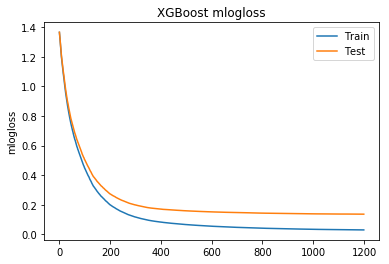

In [212]:
results2 = xgb2.evals_result()
epochs = len(results2['validation_0']['mlogloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results2['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results2['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('XGBoost mlogloss')
plt.show()

In [213]:
pred_xgb=le.inverse_transform(xgb2.predict(testF[colneeded]))

In [214]:
del testF['Severity']

In [215]:
testF['Severity']=pred_xgb
## Creating the submission file
subF=testF[['Accident_ID','Severity']]

In [216]:
subF.to_csv("predxgb_sub5.csv",index=None)

In [234]:
## checking Hard voting of three predictions 
os.listdir()

['predxgb_sub1.csv',
 'predxgb_sub2.csv',
 'predxgb_sub3.csv',
 'predxgb_sub4.csv',
 'predxgb_sub5.csv',
 'sample_submission.csv',
 'sub1.csv',
 'sub2lgb.csv',
 'test.csv',
 'train.csv',
 'votingensemble.csv']

In [235]:
sub1=pd.read_csv('sub1.csv')
predxgb_sub1=pd.read_csv('predxgb_sub1.csv')
predxgb_sub2=pd.read_csv('predxgb_sub2.csv')
predxgb_sub3=pd.read_csv('predxgb_sub3.csv')
predxgb_sub4=pd.read_csv('predxgb_sub4.csv')
predxgb_sub5=pd.read_csv('predxgb_sub5.csv')
sub2lgb=pd.read_csv('sub2lgb.csv')


In [236]:
predxgb_sub2.head()

,Accident_ID,Severity
0,1,Highly_Fatal_And_Damaging
1,10,Significant_Damage_And_Fatalities
2,14,Significant_Damage_And_Serious_Injuries
3,17,Highly_Fatal_And_Damaging
4,21,Significant_Damage_And_Fatalities


In [220]:
from statistics import mode

In [239]:
final_pred = np.array([])
for i in range(0,len(testF)):
    final_pred = np.append(final_pred, mode([predxgb_sub1['Severity'][i], predxgb_sub2['Severity'][i],
                                            predxgb_sub5['Severity'][i],predxgb_sub3['Severity'][i],
                                             predxgb_sub4['Severity'][i]]))

In [223]:
del testF['Severity']
testF['Severity']=final_pred
## Creating the submission file
subF=testF[['Accident_ID','Severity']]
subF.to_csv("votingensemble.csv",index=None)